Total number of samples in final dataset: 84000


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/60], Train Acc: 48.61%, Val Acc: 62.95%
Epoch [2/60], Train Acc: 67.67%, Val Acc: 72.60%
Epoch [3/60], Train Acc: 74.38%, Val Acc: 78.37%
Epoch [4/60], Train Acc: 78.39%, Val Acc: 79.20%
Epoch [5/60], Train Acc: 81.02%, Val Acc: 82.92%
Epoch [6/60], Train Acc: 83.26%, Val Acc: 82.64%
Epoch [7/60], Train Acc: 85.12%, Val Acc: 85.12%
Epoch [8/60], Train Acc: 86.47%, Val Acc: 84.88%
Epoch [9/60], Train Acc: 87.63%, Val Acc: 86.51%
Epoch [10/60], Train Acc: 88.71%, Val Acc: 87.30%
Epoch [11/60], Train Acc: 89.62%, Val Acc: 86.12%
Epoch [12/60], Train Acc: 90.31%, Val Acc: 88.57%
Epoch [13/60], Train Acc: 91.12%, Val Acc: 88.54%
Epoch [14/60], Train Acc: 91.66%, Val Acc: 88.10%
Epoch [15/60], Train Acc: 92.29%, Val Acc: 87.94%
Epoch [16/60], Train Acc: 92.70%, Val Acc: 88.88%
Epoch [17/60], Train Acc: 92.94%, Val Acc: 89.45%
Epoch [18/60], Train Acc: 93.47%, Val Acc: 89.00%
Epoch [19/60], Train Acc: 93.76%, Val Acc: 90.00%
Epoch [20/60], Train Acc: 93.98%, Val Acc: 90.04%
Epoch [21

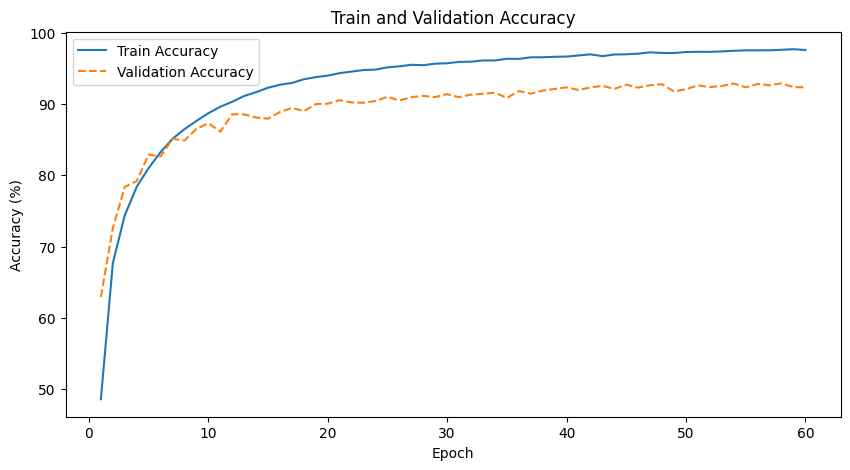

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, Subset
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random

# 1. 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# "C:/Users/USER/Desktop/Semester2"
# 2. 데이터 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0는 224x224 입력 크기 사용
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))  # CIFAR-10의 정규화 값 사용
])
# "C:\Users\jongcheol\OneDrive\바탕 화면\Semester2\train_data"
# 3. 사용자 데이터셋 불러오기
trainset_path = "C:/Users/USER/Desktop/Semester2/train_data"
user_dataset = datasets.ImageFolder(root=trainset_path, transform=transform)

# 4. CIFAR-10 데이터셋 불러오기 (훈련 데이터만 사용)
cifar10_dataset = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=transform)

# 5. 사용자 데이터셋과 CIFAR-10 데이터셋 통합
combined_dataset = ConcatDataset([user_dataset, cifar10_dataset])
combined_labels = np.concatenate((np.array([label for _, label in user_dataset.samples]),
                                  np.array(cifar10_dataset.targets)))

# 6. Augmentation 방법 설정
# aug1: Horizontal Flip + Rotation + Resized Crop
aug1_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

# aug2: Horizontal Flip + Rotation + Color Jitter
aug2_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

# 7. Augmented CIFAR-10 데이터셋 생성
aug1_cifar10_dataset = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=aug1_transform)
aug2_cifar10_dataset = datasets.CIFAR10(root="C:/Users/USER/Desktop/Semester2/CIFAR10", train=True, download=False, transform=aug2_transform)

# 각 Augmented Dataset에서 10,000개씩 샘플링
aug1_indices = random.sample(range(len(aug1_cifar10_dataset)), 15000)
aug2_indices = random.sample(range(len(aug2_cifar10_dataset)), 15000)
aug1_subset = Subset(aug1_cifar10_dataset, aug1_indices)
aug2_subset = Subset(aug2_cifar10_dataset, aug2_indices)

# 최종 데이터셋 구성: user_data 4000 + CIFAR10 50000 + aug1 10000 + aug2 10000
final_combined_dataset = ConcatDataset([combined_dataset, aug1_subset, aug2_subset])

# 최종 데이터셋의 레이블 배열 생성
aug1_labels = np.array([aug1_cifar10_dataset[i][1] for i in aug1_indices])
aug2_labels = np.array([aug2_cifar10_dataset[i][1] for i in aug2_indices])
final_combined_labels = np.concatenate((combined_labels, aug1_labels, aug2_labels))

print(f"Total number of samples in final dataset: {len(final_combined_dataset)}")

# 8. 데이터셋을 학습 및 검증 세트로 나누기 (Stratified Split)
train_idx, val_idx = train_test_split(
    np.arange(len(final_combined_labels)),
    test_size=0.2,  # 전체 데이터의 1/5을 검증 데이터로 사용
    stratify=final_combined_labels,  # 각 클래스의 비율을 유지하며 분할
    random_state=42
)

train_subset = Subset(final_combined_dataset, train_idx)
val_subset = Subset(final_combined_dataset, val_idx)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=1)

# 9. 학습 및 평가 루프 (K-Fold 루프 제거)
num_epochs = 60
train_accuracies, val_accuracies = [], []  # 전체 에포크의 정확도 저장

# EfficientNet-B0 모델 설정 (사전 학습 없음)
model3 = models.mobilenet_v2(pretrained=False)
num_classes = 10  # CIFAR-10의 클래스 수 (사용자 데이터셋도 동일한 클래스 수로 가정)
model3.classifier[1] = nn.Linear(model3.classifier[1].in_features, num_classes)
model3 = model3.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

# 학습 및 검증
for epoch in range(num_epochs):
    # === 학습 ===
    model3.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    # 학습 정확도 기록
    train_acc = 100. * correct_train / total_train
    train_accuracies.append(train_acc)

    # === 검증 ===
    model3.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model3(images)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    # 검증 정확도 기록
    val_acc = 100. * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


# 정확도 시각화
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend(loc='best')
plt.show()